In [4]:
library(tidyverse)
library(repr)
library(RColorBrewer)
library(tidymodels)

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3      ✔ yardstick 0.0.7 

Warning message:
“package ‘broom’ was built under R version 4.0.2”
Warning message:
“package ‘dials’ was built under R version 4.0.2”
Warning message:
“package ‘infer’ was built under R version 4.0.3”
Warning message:
“package ‘modeldata’ was built under R version 4.0.1”
Warning message:
“package ‘parsnip’ was built under R version 4.0.2”
Warning message:
“package ‘recipes’ was built under R version 4.0.1”
Warning message:
“package ‘tune’ was built under R version 4.0.2”
Warning message:
“package ‘workflows’ was built under R version 4.0.2”
Warning message:
“package ‘yardstick’ was built under R version 4.0.2”
── Conflicts ────

In [5]:
pulsar_data <- read_csv("https://github.com/kseniak1/DSCI100-Group-Project/raw/main/HTRU_2%5B1%5D.csv", col_names = FALSE) %>%
                rename(mean_ip = X1,
                      dev_ip = X2,
                      excess_ip = X3,
                      skewness_ip = X4,
                      mean_dm = X5,
                      dev_dm = X6,
                      excess_dm = X7,
                      skewness_dm = X8,
                      class = X9)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)



In [10]:
## Split into training and testing data
set.seed(19)
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_training <- training(pulsar_split)
pulsar_testing <- testing(pulsar_split)

In [11]:
## Table of maximum values in each column
max_data <- pulsar_training %>%
            map_dfr(max) %>%
            pivot_longer(cols = mean_ip:class, names_to = "value", values_to = "max")

## Table of minimum values in each column
min_data <- pulsar_training %>%
            map_dfr(min) %>%
            pivot_longer(cols = mean_ip:class, names_to = "value", values_to = "min")

mean_data <- pulsar_training %>%
            map_dfr(mean) %>%
            pivot_longer(cols = mean_ip:class, names_to = "value", values_to = "mean")

## Combined min, max and mean data 
min_max_mean_data <- bind_cols(min_data, max_data, mean_data) %>%
                rename(value = value...1) %>%
                select(value, max, min, mean)

min_max_mean_data

## Count number of pulsar and non-pulsar datapoints
pulsar_count <- pulsar_training %>%
                group_by(class) %>%
                summarize(n = n()) %>%
                select(class, n)
pulsar_count

New names:
* value -> value...1
* value -> value...3
* value -> value...5



value,max,min,mean
<chr>,<dbl>,<dbl>,<dbl>
mean_ip,192.617188,5.8125000,110.99001264
dev_ip,91.808628,24.7720418,46.57220318
excess_ip,7.879628,-1.8760112,0.48355769
skewness_ip,65.385974,-1.7918860,1.80628166
mean_dm,223.392141,0.2132107,12.86564391
dev_dm,110.642211,7.3704322,26.51313110
excess_dm,34.539844,-3.1392696,8.25315104
skewness_dm,1191.000837,-1.9769756,103.96069573
class,1.000000,0.0000000,0.09304231


`summarise()` ungrouping output (override with `.groups` argument)



class,n
<dbl>,<int>
0,12175
1,1249


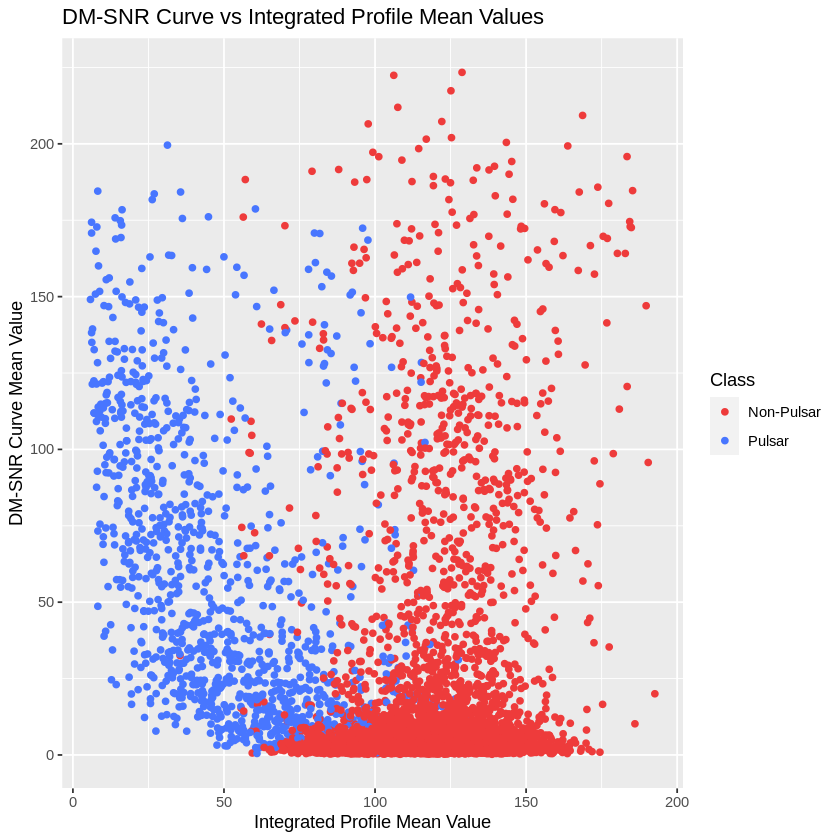

In [12]:
## Plot mean values and class
means_graph <- ggplot(pulsar_training, aes(x = mean_ip, y = mean_dm, color = as_factor(class))) +
                geom_point() +
                labs(x = "Integrated Profile Mean Value", y = "DM-SNR Curve Mean Value", color = "Class") +
                ggtitle("DM-SNR Curve vs Integrated Profile Mean Values") +
                scale_color_manual(labels = c("Non-Pulsar", "Pulsar"), values = c("brown2", "royalblue1"))
means_graph